# Crafting summary Statistics

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch

from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform

2025-03-17 17:47:52.194550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742230072.207194   72322 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742230072.211209   72322 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742230072.220820   72322 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742230072.220834   72322 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742230072.220836   72322 computation_placer.cc:177] computation placer alr

In [2]:
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

In [3]:
param_count = 15

In [4]:
prior_min = [-1] * param_count
prior_max = [1] * param_count
prior = BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

In [5]:
def create_t_x(theta, seed=None):
    """Return an t, x array for plotting based on params"""
    rng = np.random.RandomState(seed) if seed is not None else np.random.RandomState()

    dims = theta.shape[1]

    t = np.linspace(-1, 1, 200)
    ts = np.repeat(t[:, np.newaxis], theta.shape[0], axis=1)
    x = sum(
        theta[:, i] * ts**i for i in range(dims)
    ) + 0.01 * rng.randn(ts.shape[0], theta.shape[0])
    return t, x


def eval(theta, t, seed=None):
    """Evaluate the quadratic function at `t`"""
    rng = np.random.RandomState(seed) if seed is not None else np.random.RandomState()

    dims = theta.shape[1]

    return sum(theta[:, i] * t**i for i in range(dims)) + 0.01 * rng.randn(1)

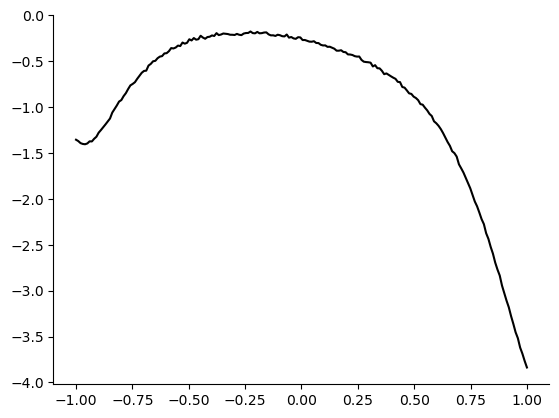

In [6]:
theta_o = np.random.uniform(-1, 1, param_count).reshape(1, -1)
t, x = create_t_x(theta_o)
plt.plot(t, x, "k")

In [7]:
# Obtaining summary statistics using two methods:

def get_n_values(theta, seed=None):
    """
    Return 3 'x' values corresponding to t=-0.5,0,0.75 as summary statistic vector
    """

    dims = theta.shape[1]

    t_values = np.linspace(-1, 1, dims).tolist()
    t_values.insert(0, -1)
    t_values.append(1)

    return np.array([eval(theta, t, seed=seed) for t in t_values]).T


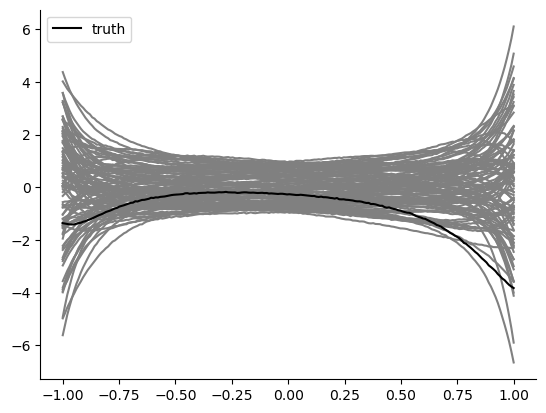

In [8]:
t, x_truth = create_t_x(theta_o)
plt.plot(t, x_truth, "k", zorder=1, label="truth")
n_samples = 100
theta = prior.sample((n_samples,))
t, x = create_t_x(theta.numpy())
plt.plot(t, x, "grey", zorder=0)
plt.legend()

In [9]:
theta = prior.sample((100000,))
x = get_n_values(theta.numpy())
x = torch.as_tensor(x, dtype=torch.float32)

In [10]:
inference = NPE(prior)

_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

 Neural network successfully converged after 142 epochs.

In [11]:
x_o = torch.as_tensor(get_n_values(theta_o), dtype=float)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    -2 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


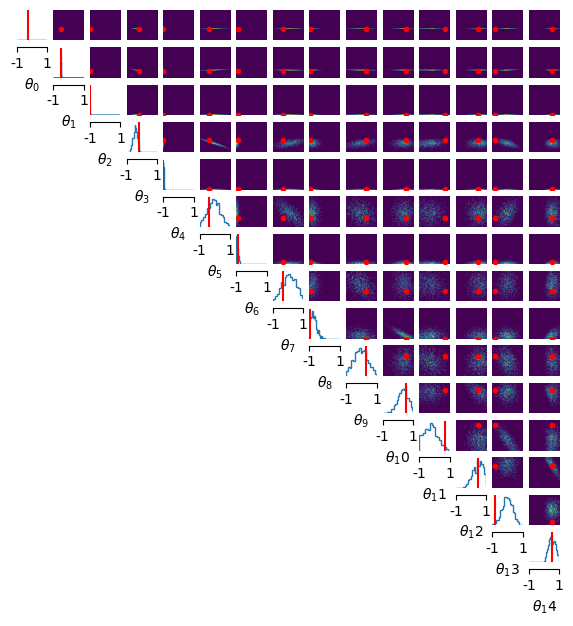

In [12]:
theta_p = posterior.sample((1000,), x=x_o)

fig, axes = pairplot(
    theta_p,
    limits=list(zip(prior_min, prior_max, strict=False)),
    ticks=list(zip(prior_min, prior_max, strict=False)),
    figsize=(7, 7),
    labels=[f"$\\theta_{i}$" for i in range(param_count)],
    fig_kwargs=dict(
        points_offdiag={"markersize": 6},
        points_colors="r",
    ),
    points=theta_o,
)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0.827% posterior samples are within the
                        prior support (for condition 0). It may take a long time
                        to collect the remaining 8925 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


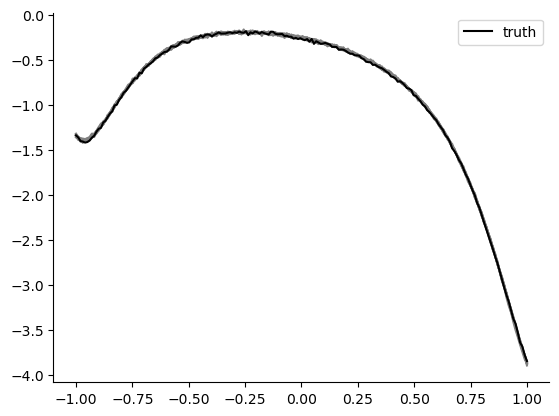

In [13]:
x_o_t, x_o_x = create_t_x(theta_o)
plt.plot(x_o_t, x_o_x, "k", zorder=1, label="truth")
theta_p = posterior.sample((100,), x=x_o)
ind_10_highest = np.argsort(np.array(posterior.log_prob(theta=theta_p, x=x_o)))[-10:]
theta_p_considered = theta_p[ind_10_highest, :]
x_t, x_x = create_t_x(theta_p_considered.numpy())
plt.plot(x_t, x_x, "grey", zorder=0)
plt.legend()